# Imports

In [ ]:
## Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    force=True
)

## Numeric imports
import pandas as pd

## File I/O
from pathlib import Path
import json

## Cheminformatics
from rdkit import Chem

# Param input

In [ ]:
mono_data_path : Path = Path('processed_monomer_data') / 'clean_smarts_digroup.csv'
rxn_mech_dir   : Path = Path('rxn_smarts')

rxns_from_smarts : bool = True#False

## Load processed monomer starting structures

In [ ]:
logging.info(f'Loading processed data from {mono_data_path.stem}')
digroup_table = pd.read_csv(mono_data_path, index_col=[0])
tables_by_chem = {
    chemistry : digroup_table[digroup_table['Chemistry'] == chemistry].dropna(axis=1).reset_index(drop=True)
        for chemistry in set(digroup_table['Chemistry'])
}

## Load rxn mechanisms

In [ ]:
from polymerist.rdutils.reactions import reactions, reactors


reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

logging.info(f'Loading reaction mechanisms (from {"SMARTS" if rxns_from_smarts else "MDL files"})')
if rxns_from_smarts:
    with (rxn_mech_dir / 'rxn_smarts.json').open('r') as rxn_file:
        rxns = {
            chemistry : reactions.AnnotatedReaction.from_smarts(rxn_SMARTS)
                for chemistry, rxn_SMARTS in json.load(rxn_file).items()
        }
else:
    # from files
    rxns = {
        chemistry : reactions.AnnotatedReaction.from_rxnfile(rxn_mech_dir / f'{chemistry}.rxn')
            for chemistry in reaction_pairs.keys()
    }

# Polymerizing fragments

## Example for polymerization of individual molecule

In [ ]:
chemistry = 'urethane'
idx = 3

rxn_pathway = rxns[chemistry]
chem_tab = tables_by_chem[chemistry]
chem_entry = chem_tab.loc[idx]

reactants = {
    react_name : Chem.MolFromSmarts(chem_entry[react_name])
        for react_name in reaction_pairs[chemistry]
}

reactor = reactors.PolymerizationReactor(rxn_pathway)
for (dimer, pair) in reactor.propagate([i for i in reactants.values()]):
    display(dimer)
    for frag in pair:
        display(frag)
    print('='*50)

## Polymerize all SMILES into well-specified fragments with ports

In [ ]:
from polymerist.monomers import MonomerGroup
from polymerist.monomers.substruct import specification

from polymerist.rdutils.labeling import molwise



mono_info_dir  : Path = Path('monomer_files_dup')
mono_info_dir.mkdir(exist_ok=True)

for chemistry, smarts_table in tables_by_chem.items():
    chem_dir = mono_info_dir / chemistry
    chem_dir.mkdir(exist_ok=True)

    for i, sample in smarts_table.iterrows():
        logging.info(f'Generating fragments for {chemistry} #{i}')
        # look up reactive groups and pathway by chemistry
        rxn_group_names = reaction_pairs[chemistry]
        rxn = rxns[chemistry]

        # read reactant monomers from digroup_table
        initial_reactants = []
        for j, group_name in enumerate(rxn_group_names):
            reactant = Chem.MolFromSmarts(sample[group_name])
            for atom in reactant.GetAtoms():
                atom.SetProp('reactant_group', group_name)
            
            initial_reactants.append(reactant)
        mono_info = MonomerGroup()

        # first round of polymerization (initiation)
        reactor = reactors.PolymerizationReactor(rxn)
        for dimer, frags in reactor.propagate(initial_reactants):
            for assoc_group_name, rdfragment in zip(rxn_group_names, frags):
                # label and sanitize fragments
                molwise.clear_atom_isotopes(rdfragment, in_place=True)
                molwise.assign_ordered_atom_map_nums(rdfragment, in_place=True) # number monomers
                Chem.Kekulize(rdfragment, clearAromaticFlags=True) # convert aromatic bonds to single-double
                Chem.SanitizeMol(rdfragment, sanitizeOps=specification.SANITIZE_AS_KEKULE)

                # generate spec-compliant SMARTS
                raw_smarts = Chem.MolToSmarts(rdfragment)
                spec_smarts = specification.compliant_mol_SMARTS(smarts=raw_smarts)

                # record to monomer group
                affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
                mono_info.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]

        mono_info.to_file(chem_dir / f'{chemistry}_{i}.json')

[5*]C(=O)N([H])c1c([H])c([H])c2c(c1[H])C(=O)N(c1c([H])c([H])c(P(=O)(c3c([H])c([H])c(N4C(=O)c5c([H])c([H])c(N=C=O)c([H])c5C4=O)c([H])c3[H])C([H])([H])[H])c([H])c1[H])C2=O 
 [#8]=[#6](=[#7](-[#6]1=[#6](-[#6](=[#6]2-[#6](=[#6]-1-[#1])-[#6](=[#8])-[#7](-[#6]-2=[#8])-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#1])-[#1])-[#15](-[#6](-[#1])(-[#1])-[#1])(=[#8])-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#1])-[#1])-[#7]1-[#6](=[#8])-[#6]2-[#6](-[#6]-1=[#8])=[#6](-[#6](=[#6](-[#6]=2-[#1])-[#1])-[#7]=[#6]=[#8])-[#1])-[#1])-[#1])-[#1])-[#1])-[#1])-[#1])-[#1])-[5#0]


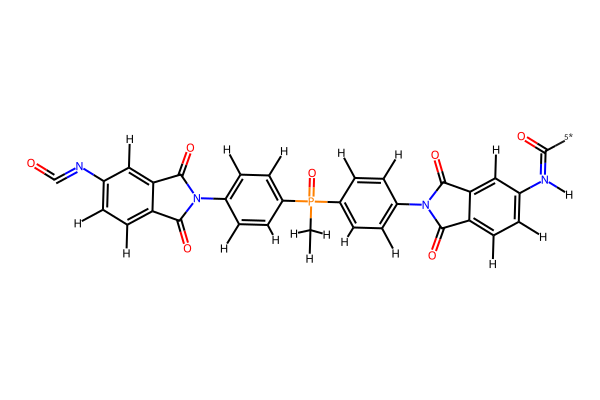

[1*]OC([H])([H])C([H])([H])Oc1c(Br)c([H])c(C(c2c([H])c(Br)c(OC([H])([H])C([H])([H])O[H])c(Br)c2[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1Br 
 [#8](-[#6](-[#6](-[#8]-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#35])-[#1])-[#6](-[#6](-[#1])(-[#1])-[#1])(-[#6](-[#1])(-[#1])-[#1])-[#6]1=[#6](-[#6](-[#35])=[#6](-[#6](=[#6]-1-[#1])-[#35])-[#8]-[#6](-[#6](-[#8]-[#1])(-[#1])-[#1])(-[#1])-[#1])-[#1])-[#1])-[#35])(-[#1])-[#1])(-[#1])-[#1])-[1#0]


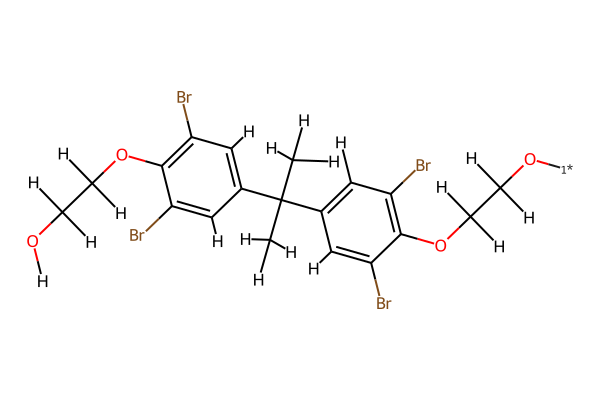

[5*]C(=O)N([H])c1c([H])c([H])c2c(c1[H])C(=O)N(c1c([H])c([H])c(P(=O)(c3c([H])c([H])c(N4C(=O)c5c([H])c([H])c(N([H])C([5*])=O)c([H])c5C4=O)c([H])c3[H])C([H])([H])[H])c([H])c1[H])C2=O 
 [#8]=[#6](=[#7](-[#6]1-[#6](=[#6]2-[#6](-[#7](-[#6](-[#6]-2=[#6](-[#6]=1-[#1])-[#1])=[#8])-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#1])-[#1])-[#15](-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#1])-[#1])-[#7]1-[#6](-[#6]2-[#6](-[#6]-1=[#8])=[#6](-[#6](=[#6](-[#6]=2-[#1])-[#7](=[#6](=[#8])-[5#0])-[#1])-[#1])-[#1])=[#8])-[#1])-[#1])(-[#6](-[#1])(-[#1])-[#1])=[#8])-[#1])-[#1])=[#8])-[#1])-[#1])-[5#0]


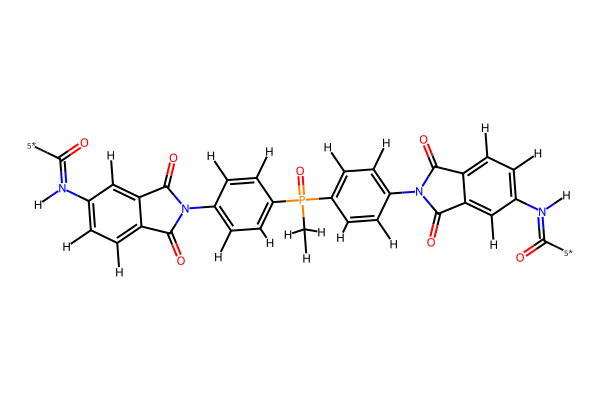

[1*]OC([H])([H])C([H])([H])Oc1c(Br)c([H])c(C(c2c([H])c(Br)c(OC([H])([H])C([H])([H])O[1*])c(Br)c2[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1Br 
 [#8](-[#6](-[#6](-[#8]-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#35])-[#1])-[#6](-[#6]1=[#6](-[#6](=[#6](-[#6](=[#6]-1-[#1])-[#35])-[#8]-[#6](-[#6](-[#8]-[1#0])(-[#1])-[#1])(-[#1])-[#1])-[#35])-[#1])(-[#6](-[#1])(-[#1])-[#1])-[#6](-[#1])(-[#1])-[#1])-[#1])-[#35])(-[#1])-[#1])(-[#1])-[#1])-[1#0]


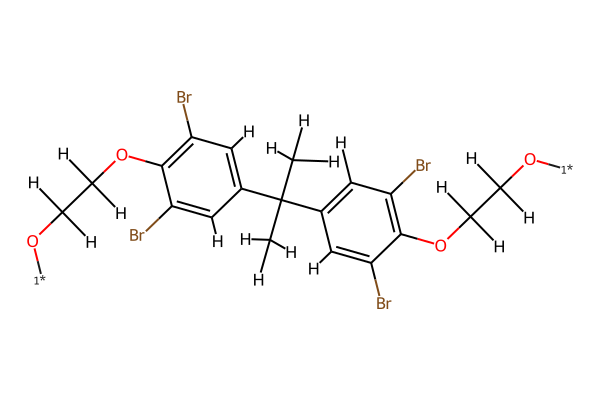

In [55]:

chemistry = 'urethane'
idx = 11

rxn_group_names = reaction_pairs[chemistry]
rxn = rxns[chemistry]
smarts_table = tables_by_chem[chemistry]
sample = smarts_table.loc[idx]

# read reactant monomers from digroup_table
initial_reactants = []
for j, group_name in enumerate(rxn_group_names):
    reactant = Chem.MolFromSmarts(sample[group_name])
    for atom in reactant.GetAtoms():
        atom.SetProp('reactant_group', group_name)
    
    initial_reactants.append(reactant)
mono_info = MonomerGroup()

reactor = reactors.PolymerizationReactor(rxn)
for dimer, frags in reactor.propagate(initial_reactants):
    for fragment in frags:
        smiles = Chem.MolToSmiles(fragment)
        smarts = Chem.MolToSmarts(fragment)
        print(smiles, '\n', smarts)

        f2 = Chem.MolFromSmarts(smarts)
        display(f2)
        # display(fragment)


In [59]:
from polymerist.rdutils import rdkdraw
rdkdraw.set_rdkdraw_size(400, 3/2)
from polymerist.rdutils.amalgamation import smileslib


orig = frags[0]
for bond in orig.GetBonds():
    bond_query = smileslib.BOND_SMARTS_BY_ORDER[bond.GetBondType()]
    bond.SetQuery(bond_query)


smarts = Chem.MolToSmarts(orig)
m = Chem.MolFromSmarts(smarts)
# molwise.assign_ordered_atom_map_nums(m, in_place=True)

print(smarts)
display(m)

AttributeError: 'Bond' object has no attribute 'SetQuery'

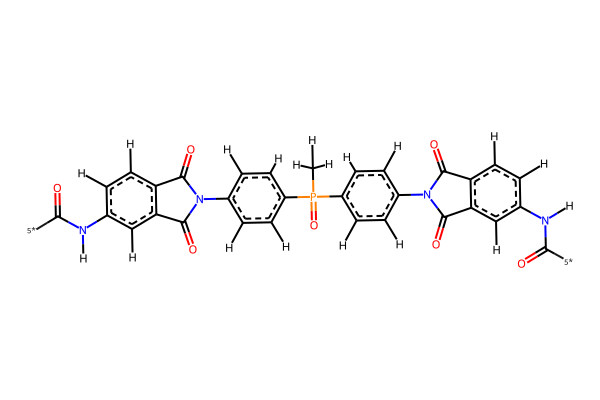

In [57]:
orig

In [58]:
for atom in orig.GetAtoms():
    print(atom.GetSymbol(), atom.GetAtomMapNum())
    for bond in atom.GetBonds():
        print(f'\tDegree = {bond.GetBondTypeAsDouble()}')
        print('\t', bond.DescribeQuery()) 

O 0
	Degree = 2.0
	 BondOrder 2 = val

C 0
	Degree = 2.0
	 BondOrder 2 = val

	Degree = 1.0
	 BondOrder 2 = val

	Degree = 1.0
	 
N 0
	Degree = 1.0
	 BondOrder 2 = val

	Degree = 1.0
	 BondOrder 1 = val

	Degree = 1.0
	 
C 0
	Degree = 1.0
	 BondOrder 1 = val

	Degree = 1.5
	 BondOrder 1 = val

	Degree = 1.5
	 BondOrder 2 = val

H 0
	Degree = 1.0
	 
C 0
	Degree = 1.5
	 BondOrder 1 = val

	Degree = 1.5
	 BondOrder 2 = val

	Degree = 1.0
	 BondOrder 1 = val

C 0
	Degree = 1.5
	 BondOrder 2 = val

	Degree = 1.5
	 BondOrder 1 = val

	Degree = 1.0
	 BondOrder 1 = val

C 0
	Degree = 1.5
	 BondOrder 2 = val

	Degree = 1.0
	 BondOrder 1 = val

	Degree = 1.5
	 BondOrder 1 = val

H 0
	Degree = 1.0
	 BondOrder 1 = val

C 0
	Degree = 1.5
	 BondOrder 1 = val

	Degree = 1.5
	 BondOrder 2 = val

	Degree = 1.0
	 BondOrder 1 = val

H 0
	Degree = 1.0
	 BondOrder 1 = val

C 0
	Degree = 1.0
	 BondOrder 1 = val

	Degree = 1.0
	 BondOrder 1 = val

	Degree = 2.0
	 BondOrder 2 = val

C 0
	Degree = 1.5
	 BondOr

In [ ]:

    for assoc_group_name, rdfragment in zip(rxn_group_names, frags):
        # label and sanitize fragments
        molwise.clear_atom_isotopes(rdfragment, in_place=True)
        molwise.assign_ordered_atom_map_nums(rdfragment, in_place=True) # number monomers
        Chem.Kekulize(rdfragment, clearAromaticFlags=True) # convert aromatic bonds to single-double
        Chem.SanitizeMol(rdfragment, sanitizeOps=specification.SANITIZE_AS_KEKULE)

        # generate spec-compliant SMARTS
        raw_smarts = Chem.MolToSmarts(rdfragment)
        spec_smarts = specification.compliant_mol_SMARTS(smarts=raw_smarts)

        # record to monomer group
        affix = 'TERM' if MonomerGroup.is_terminal(rdfragment) else 'MID'
        mono_info.monomers[f'{assoc_group_name}_{affix}'] = [spec_smarts]
